In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV as RSCV
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def plotGridSearchParams(cv_results_, param_grid, N=None):
    """
    Plots Grid Search parameter tuning results, showing train and validation MSE 
    for each hyperparameter tested.

    Parameters:
    -----------
    cv_results_ : dict
        The cross-validation results from `GridSearchCV.cv_results_`.
    param_grid : dict
        The parameter grid used in the grid search.
    N : int, optional
        The number of top results to consider (default: None, i.e., all results).
    """

    # Convert cv_results_ dictionary to DataFrame
    dfCVResults = pd.DataFrame(cv_results_)

    # Ensure hyperparameter columns are numeric where possible
    for param in param_grid.keys():
        param_col = f'param_{param}'
        if param_col in dfCVResults.columns:
            dfCVResults[param_col] = pd.to_numeric(dfCVResults[param_col],
                                                   errors="coerce")

    # Extract best parameters based on highest mean test score
    best_params = dfCVResults.sort_values("mean_test_score",
                                          ascending=False).iloc[0].params

    # Filter out unreasonable results
    dfCVResults_ = dfCVResults[dfCVResults["mean_train_score"] >= -10].copy()
    dfCVResults_ = dfCVResults_.sort_values("mean_test_score", ascending=False)

    # Keep only top N results if specified
    if N is not None:
        dfCVResults_ = dfCVResults_.iloc[:N]

    # Initialize figure
    fig, axes = plt.subplots(1, len(param_grid.keys()), figsize=(15, 5))
    color_validation = "green"
    color_train = "blue"

    # Iterate over parameters in the grid
    for ax, param in zip(axes, param_grid.keys()):
        param_col = f'param_{param}'

        # Check if parameter column exists
        if param_col not in dfCVResults_.columns:
            print(f"Skipping {param}: not found in results.")
            continue

        # Drop NaN values that might have been introduced by `pd.to_numeric`
        dfParam = dfCVResults_.groupby(param_col).mean(
            numeric_only=True).dropna()

        # Compute mean and std for train/test scores grouped by the current parameter
        mean_test = dfParam[[f"split{i}_test_score"
                             for i in range(5)]].mean(axis=1)
        std_test = dfParam[[f"split{i}_test_score"
                            for i in range(5)]].std(axis=1)

        mean_train = dfParam[[f"split{i}_train_score"
                              for i in range(5)]].mean(axis=1)
        std_train = dfParam[[f"split{i}_train_score"
                             for i in range(5)]].std(axis=1)

        # Plot validation results
        ax.scatter(mean_test.index,
                   mean_test,
                   marker="x",
                   color=color_validation)
        ax.plot(mean_test.index,
                mean_test,
                color=color_validation,
                label="Validation")
        ax.fill_between(mean_test.index,
                        mean_test - std_test,
                        mean_test + std_test,
                        alpha=0.2,
                        color=color_validation)

        # Plot training results
        ax.scatter(mean_train.index, mean_train, marker="x", color=color_train)
        ax.plot(mean_train.index, mean_train, color=color_train, label="Train")
        ax.fill_between(mean_train.index,
                        mean_train - std_train,
                        mean_train + std_train,
                        alpha=0.2,
                        color=color_train)

        # Add vertical line for best parameter value
        ax.axvline(best_params[param], color="red", linestyle="--")

        # Labels and title
        ax.set_ylabel("MSE")
        ax.set_xlabel(param)
        ax.set_title(f"Tuning {param}")
        ax.legend()
        ax.grid(True, linestyle="--", linewidth=0.5)

    # Adjust layout and title
    plt.suptitle("Grid Search Hyperparameter Tuning Results", fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
def FIPlot(best_estimator, feature_columns):
    FI = best_estimator.feature_importances_
    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot(1, 1, 1)
    feature_importdf = pd.DataFrame(data={
        "variables": feature_columns,
        "feat_imp": FI
    })

    feature_importdf.sort_values(by="feat_imp", ascending=True, inplace=True)
    sns.barplot(feature_importdf,
                x='feat_imp',
                y='variables',
                dodge=False,
                ax=ax)

    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')

In [4]:
def plotGridSearchScore(cv_results_):
    """
    Plots the evolution of the training and validation scores over iterations 
    during Grid Search.

    Parameters:
    -----------
    cv_results_ : dict
        The cross-validation results from `GridSearchCV.cv_results_`.
    """

    # Convert to DataFrame
    dfCVResults = pd.DataFrame(cv_results_)

    # Filter out unreasonable values
    dfCVResults = dfCVResults[dfCVResults["mean_train_score"] >= -10].dropna()

    # Extract mean and std of train/test scores
    mean_train = dfCVResults["mean_train_score"]
    std_train = dfCVResults["std_train_score"]
    mean_test = dfCVResults["mean_test_score"]
    std_test = dfCVResults["std_test_score"]

    # Define colors
    color_validation = "green"
    color_train = "blue"

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot mean train & validation scores
    ax.plot(mean_train, label="Train", color=color_train)
    ax.plot(mean_test, label="Validation", color=color_validation)

    # Fill standard deviation area
    ax.fill_between(dfCVResults.index,
                    mean_train - std_train,
                    mean_train + std_train,
                    alpha=0.2,
                    color=color_train)
    ax.fill_between(dfCVResults.index,
                    mean_test - std_test,
                    mean_test + std_test,
                    alpha=0.2,
                    color=color_validation)

    # Add a vertical line at the minimum validation score
    if not mean_test.empty:
        pos_min = mean_test.idxmin()
        ax.axvline(pos_min,
                   color="red",
                   linestyle="--",
                   label="Min Validation MSE")

    # Labels and title
    ax.set_xlabel("Iteration")
    ax.set_ylabel("MSE")
    ax.set_title("Grid Search Score Over Iterations")
    ax.legend()
    ax.grid(True, linestyle="--", linewidth=0.5)

    plt.show()

In [5]:
# def plotGridSearchParams(cv_results_, param_grid, N=None):
#     dfCVResults = pd.DataFrame(cv_results_)
#     best_params = dfCVResults.sort_values('mean_test_score',
#                                           ascending=False).iloc[0].params
#     mask_raisonable = dfCVResults['mean_train_score'] >= -10
#     dfCVResults_ = dfCVResults[mask_raisonable]
#     dfCVResults_.sort_values('mean_test_score', ascending=False, inplace=True)
#     if N is not None:
#         dfCVResults_ = dfCVResults_.iloc[:10]
#     fig = plt.figure(figsize=(15, 5))
#     for i, param in enumerate(param_grid.keys()):

#         dfParam = dfCVResults_.groupby(f'param_{param}')[[
#             'split0_test_score', 'split1_test_score', 'split2_test_score',
#             'split3_test_score', 'split4_test_score', 'mean_test_score',
#             'std_test_score', 'rank_test_score', 'split0_train_score',
#             'split1_train_score', 'split2_train_score', 'split3_train_score',
#             'split4_train_score', 'mean_train_score', 'std_train_score'
#         ]].mean()

#         mean_test = abs(dfParam[[f'split{i}_test_score'
#                                  for i in range(5)]].mean(axis=1))
#         std_test = abs(dfParam[[f'split{i}_test_score'
#                                 for i in range(5)]].std(axis=1))

#         mean_train = abs(dfParam[[f'split{i}_train_score'
#                                   for i in range(5)]].mean(axis=1))
#         std_train = abs(dfParam[[f'split{i}_train_score'
#                                  for i in range(5)]].std(axis=1))

#         # plot mean values with std
#         color_tim = 'green'
#         color_xgb = 'blue'
#         ax = plt.subplot(1, len(param_grid.keys()), i + 1)
#         ax.scatter(x=mean_test.index,
#                    y=mean_test.values,
#                    marker='x',
#                    color=color_tim)
#         ax.plot(mean_test.index,
#                 mean_test,
#                 color=color_tim,
#                 label='validation')
#         ax.fill_between(mean_test.index,
#                         mean_test - std_test,
#                         mean_test + std_test,
#                         alpha=0.2,
#                         color=color_tim)

#         ax.scatter(x=mean_train.index,
#                    y=mean_train.values,
#                    marker='x',
#                    color=color_xgb)
#         ax.plot(mean_train.index, mean_train, color=color_xgb, label='train')
#         ax.fill_between(mean_train.index,
#                         mean_train - std_train,
#                         mean_train + std_train,
#                         alpha=0.2,
#                         color=color_xgb)
#         # add vertical line of best param
#         ax.axvline(best_params[param], color='red', linestyle='--')

#         ax.set_ylabel('MSE []')
#         ax.set_title(param)
#         ax.legend()

#     plt.suptitle('Grid search results')
#     plt.tight_layout()
#     # fig.savefig('/scratch-fourth/acremona/grid_search_params.png')

# def plotGridSearchScore(cv_results_):
#     dfCVResults = pd.DataFrame(cv_results_)
#     mask_raisonable = dfCVResults['mean_train_score'] >= -10
#     dfCVResults = dfCVResults[mask_raisonable]

#     fig = plt.figure(figsize=(10, 5))
#     mean_train = abs(dfCVResults.mean_train_score)
#     std_train = abs(dfCVResults.std_train_score)
#     mean_test = abs(dfCVResults.mean_test_score)
#     std_test = abs(dfCVResults.std_test_score)

#     color_tim = 'green'
#     color_xgb = 'blue'

#     plt.plot(mean_train, label='train', color=color_xgb)
#     plt.plot(mean_test, label='validation', color=color_tim)

#     # add std
#     plt.fill_between(dfCVResults.index,
#                      mean_train - std_train,
#                      mean_train + std_train,
#                      alpha=0.2,
#                      color=color_xgb)
#     plt.fill_between(dfCVResults.index,
#                      mean_test - std_test,
#                      mean_test + std_test,
#                      alpha=0.2,
#                      color=color_tim)

#     # Add a line at the minimum
#     pos_min = dfCVResults.mean_test_score.abs().idxmin()
#     plt.axvline(pos_min, color='red', linestyle='--', label='min validation')

#     plt.xlabel('Iteration')
#     plt.ylabel('MSE []')
#     plt.title('Grid search score over iterations')
#     plt.legend()
#     # fig.savefig('/scratch-fourth/acremona/grid_search_score.png')

In [6]:
# Set all random seeds at the beginning of your script
seed = 42
random.seed(seed)
np.random.seed(seed)

# load data and separate into features and labels
# data = pd.read_csv(
#     '/scratch-fourth/acremona/calibrated_cprec_for_extrapolation.csv')
data = pd.read_csv('calibrated_cprec_for_extrapolation.csv')

X = data.drop(
    ['RGIId', 'avg_c_prec'],
    axis=1)  #'Aspect','Zmin', 'Lmax', 'Area', 'Zmax', 'Zmed', 'Slope'
y = data[['avg_c_prec']]

# split train test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=seed)

# Define Parameter Grid and Initial Parameters
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators':
    [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
}

param_init = {
    'objective': 'reg:squarederror',  #'reg:absoluteerror',
    'tree_method': 'hist',
    'random_state': seed,
}

ml_model = xgb.XGBRegressor(**param_init)

cv = 5
rscv = RSCV(ml_model,
            param_grid,
            n_iter=60,
            cv=cv,
            verbose=1,
            scoring=None,
            refit=True,
            error_score="raise",
            return_train_score=True,
            random_state=seed).fit(X_train, y_train)

print(f"Done for {ml_model}!")
print("Best parameters:\n", rscv.best_params_)
print("Best score:\n", rscv.best_score_)
print(' Best estimator : \n', rscv.best_estimator_)
print('cv results : \n', rscv.cv_results_)
print('cv results : \n', rscv.cv_results_['param_max_depth'])
print('cv results : \n', rscv.cv_results_['mean_test_score'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)!
Best parameters:
 {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.2}
Best score:
 0.31798998117446897
 Best estimator : 
 XGBRegressor(base_score=None, booster=None, callback

/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


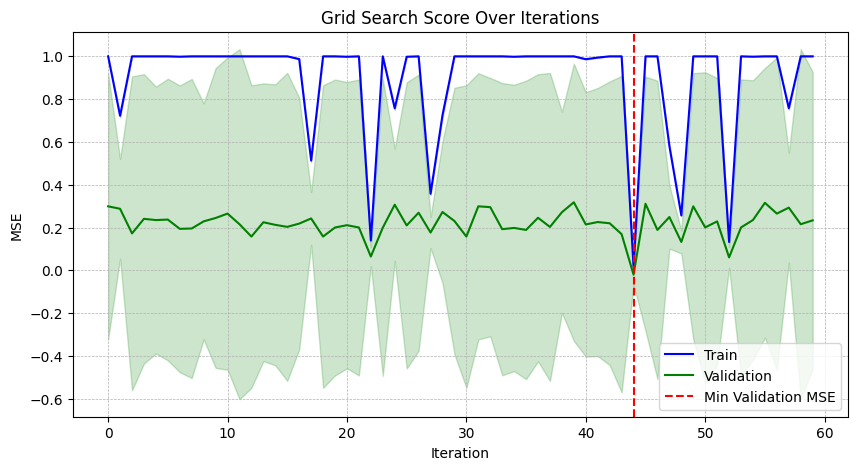

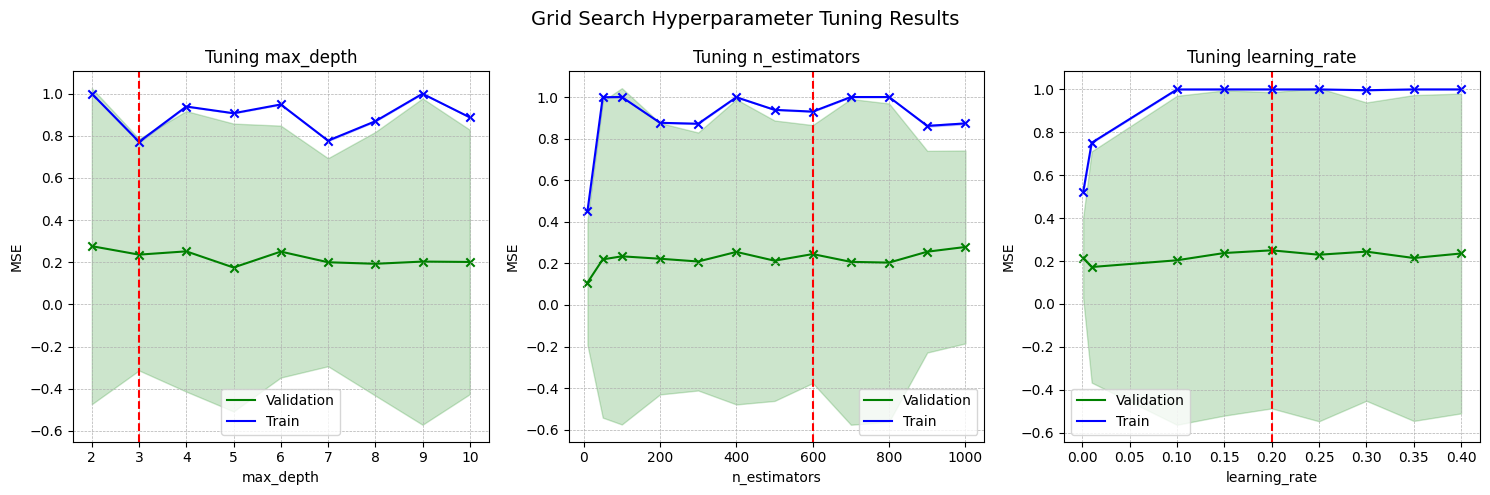

In [7]:
plotGridSearchScore(rscv.cv_results_)
plotGridSearchParams(rscv.cv_results_, param_grid)

y_test      avg_c_prec
31    2.028571
5     1.533333
32    1.700000
13    1.600000
19    1.983333
49    2.166667
41    1.575000
26    1.400000
43    2.000000
predictions  [1.9149784 1.4778162 1.2613841 1.5886154 1.8889116 2.146527  1.3732909
 1.8793828 1.5156703]
RMSE prediction 
 0.2834097589674845


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


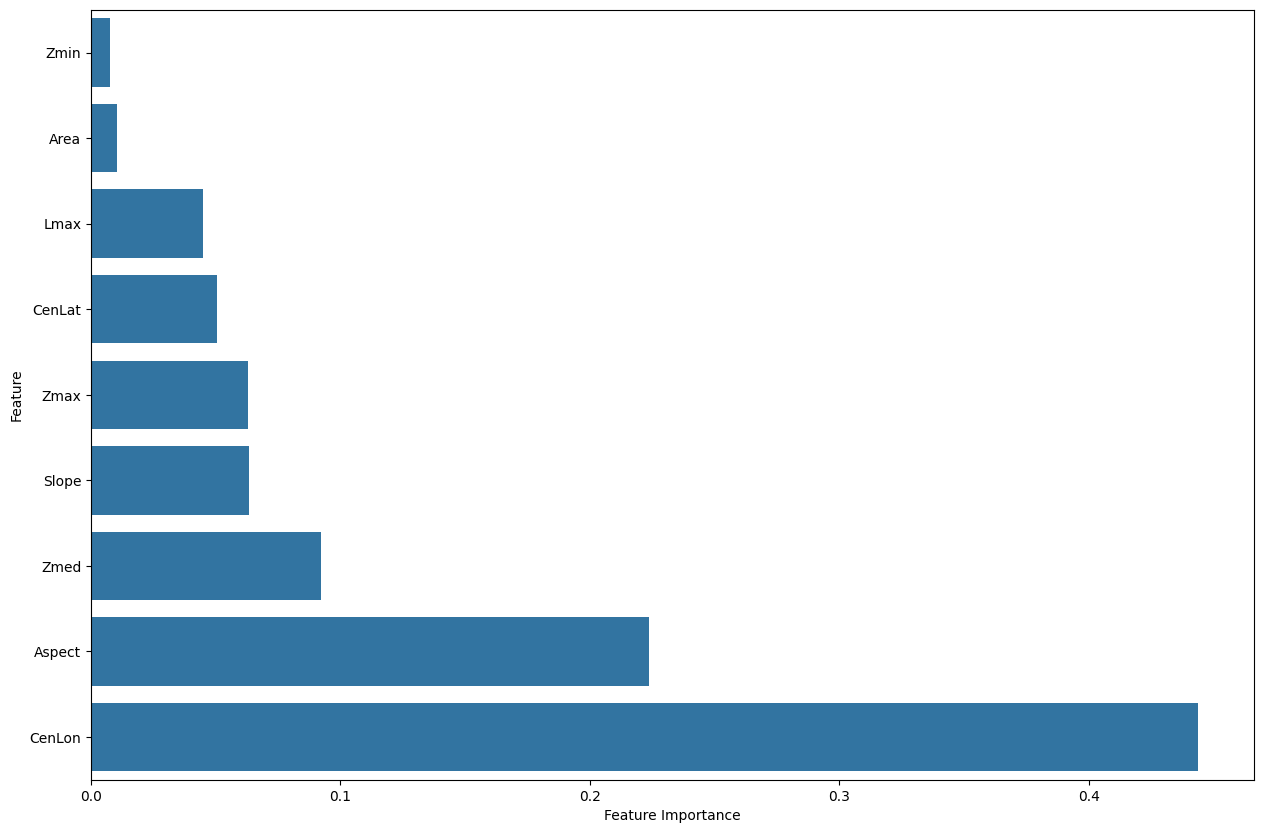

In [8]:
## 5. Make Predictions on the Test Set with the Best Model
best_model = rscv.best_estimator_
predictions = best_model.predict(X_test)
print('y_test ', y_test)
print('predictions ', predictions)
print('RMSE prediction \n',
      mean_squared_error(y_test, predictions, squared=False))

# plot_importance(best_model, max_num_features=15)

feature_important = best_model.get_booster().get_score(
    importance_type='weight')
FIPlot(best_model, X_train.columns)

{'objective': 'reg:squarederror', 'tree_method': 'hist', 'random_state': 42, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 800}
y_test      avg_c_prec
31    2.028571
5     1.533333
32    1.700000
13    1.600000
19    1.983333
49    2.166667
41    1.575000
26    1.400000
43    2.000000
predictions  [1.8868599 1.4583545 1.2514981 1.6178868 1.8926873 2.1583655 1.3918661
 1.8805249 1.4785221]
RMSE prediction 
 0.2928490148944824


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


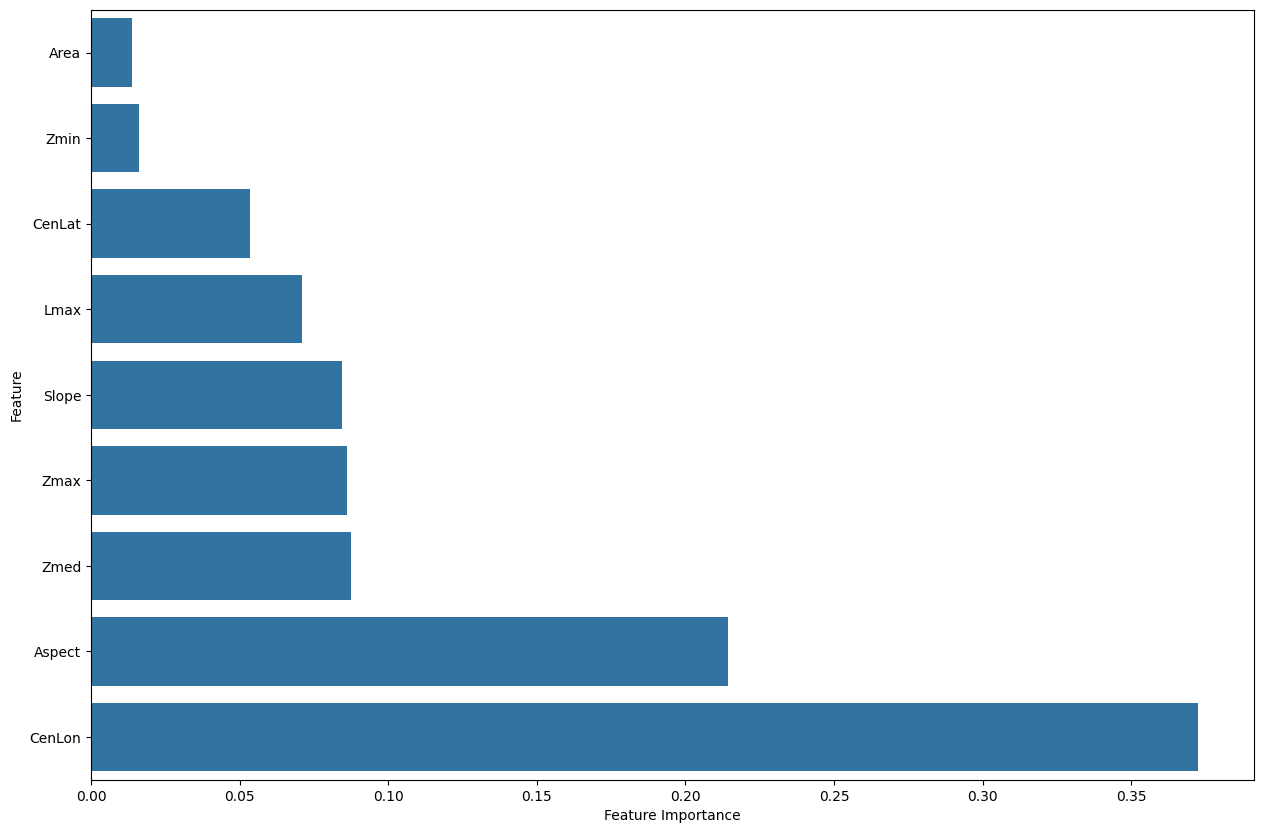

In [9]:
## 6. Make Predictions on the Test Set with the a custom model
# Custom model
custom_params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 800}
params = {**param_init, **custom_params}
print(params)
custom_model = xgb.XGBRegressor(**params)
custom_model.fit(X_train, y_train)

# Make predictions:
predictions = custom_model.predict(X_test)
print('y_test ', y_test)
print('predictions ', predictions)
print('RMSE prediction \n',
      mean_squared_error(y_test, predictions, squared=False))

# plot_importance(custom_model, max_num_features=15)
FIPlot(custom_model, X_train.columns)